# **Neural Style Transfer**

*Implementation of [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) created by Gatys et al. (2015)*

Neural Style Transfer (NST) is one of the oldest, and most frequently cited example of Art-Creating networks beside Generative Adversarial Networks (GAN) and networks like DALL-E or Stable Diffusion. 

It merges content image with style image by optimizing the cost function per pixel to produce a mixture of both. It leverages the VGG19 or InceptionV3 CNN models trained on imagenet to extract some features from them. This method is called transfer learning.

Classic NST is slow and noisy and tends toward patterns rather than features. Check Fast_NST notebook in this repository so you can compare the significantly enhanced version.

### **List of contents:**
1. Dataset preparation.
2. Extracting the Style layers and content layer.
3. Style and content cost function.
4. Train step function.
5. Generate the image.

In [257]:
import tensorflow as tf
import numpy as np
import cv2

**Important info about Google Colab:**

1. *If you are using Google Colab the data can be imported from google drive, before doing so, include the code below.*
2. *Images are loaded via openCV, there is a patch for Google Colab for imshow function. Then you have to use cv2_imshow instead of cv2.imshow*
3. *Enable the GPU runtime!*

In [258]:
# from google.colab.patches import cv2_imshow
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Images preparation**
**Things we need:**

* **Content image:** for example your social media photo or anything else.
* **Style image:** style to apply on our content image.
* **Generated image** where the results are computed. Its initial value can include random noise.




### **1.1 Load and preprocess content and style images:**
- OpenCV stores images in BGR format. If you whish to operate in grayscale, change BGR2GRAY, remember that grayscale has only one channel so you should convert both image and style to RGB or convert again the grayscale to RGB.
- The images are further reshaped and converted to float32.


Content image:
(300, 400, 3) 



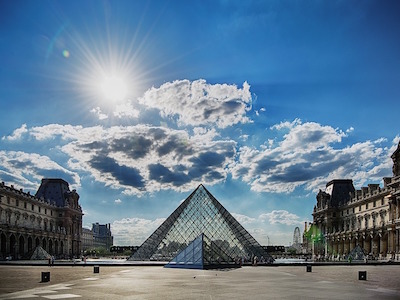


Style image:
(300, 400, 3) 



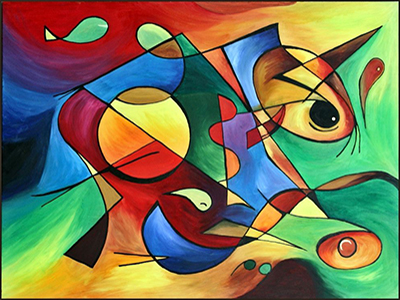

In [259]:
IMG_WIDTH = 400
IMG_HEIGHT = 300
COLOR_CHANNELS = 3

CONTENT_IMAGE_URL = "img/louvre-small.jpg"
STYLE_IMAGE_URL = "img/k3.jpg"

def load_image(url, width, height, color_mode):
    image = cv2.imread(url)
    image = cv2.resize(image, (width, height))
    
    print(image.shape, "\n")
    if cv2_imshow:
        cv2_imshow(image)
    else:
        cv2.imshow(image)

    image = cv2.cvtColor(image, color_mode)
    image = np.reshape(image, ((1,) + image.shape))
    image = tf.Variable(tf.image.convert_image_dtype(image, tf.float32))

    return image


print("\nContent image:")
content_image = load_image(CONTENT_IMAGE_URL, IMG_WIDTH, IMG_HEIGHT, cv2.COLOR_BGR2RGB)

print("\nStyle image:")
style_image = load_image(STYLE_IMAGE_URL, IMG_WIDTH, IMG_HEIGHT, cv2.COLOR_BGR2RGB)

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

### **1.2 Initialize generated image**
**There are two options:**

1.   Use content image as entry point.
2.   Add noise to content image. Theoretically this allows to transform the image better but unfortunately it makes the image more grainy or non-related to content image if there is too much of it.



In [260]:
def add_noise(image, noise_range):
    noise = tf.random.uniform(image.shape, -noise_range, noise_range)

    image = tf.add(image, noise)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image = tf.Variable(tf.image.convert_image_dtype(image, tf.float32))

    return image


## **2. Load the VGG19 and extract the Style and Content layers**


### **2.1 Functions to load the desired model**
The function below loads the model and extract layers for style and content. It will use ImageNet weights. 

*Optionally the model can be pre-downloaded and loaded from file but I don't want to include them directly in repository.*

In [261]:
def load_VGG19():

    model = tf.keras.applications.VGG19(
        include_top = False,
        input_shape = (IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS),
        weights = 'imagenet'
    )

    STYLE_LAYERS = [
        ('block1_conv1', 0.2),
        ('block2_conv1', 0.2),
        ('block3_conv1', 0.2),
        ('block4_conv1', 0.2),
        ('block5_conv1', 0.2)
    ]

    CONTENT_LAYER = [('block5_conv4', 1)]

    model.trainable = False

    return model, STYLE_LAYERS, CONTENT_LAYER

### **2.2 Extract the layers**
In this block you can choose your network.

*After some research I've found that some people uses as content layer block5_conv4, block5_conv2 or block4_conv2.*

*0.2 weights sums to 1 equally, does it matter if we change it?*

In [262]:
model, STYLE_LAYERS, CONTENT_LAYER = load_VGG19()

outputs = [model.get_layer(layer[0]).output for layer in STYLE_LAYERS + CONTENT_LAYER]

model = tf.keras.Model([model.input], outputs)


## **3. Layer style, content and style cost functions**



### **3.1 Content cost function:**

$J_{content}(C,G)= \dfrac{1}{4 \times n_H \times n_W \times n_C}\sum (a^{(C)} - a^{(G)})^2$

* $n_H, n_W, n_C$ are dimentions of hidden layer.
* $a$ is the hidden layer activation selected as content layer.

In [263]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])

    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4.0 * n_H * n_W * n_C)
    
    return J_content

### **3.2 Single layer style cost function:**

$J_{style}^{[l]}(S,G)= \dfrac{1}{4 \times n_C^2 \times (n_H \times n_W)^2}\sum_{i=1}^{n_C}\sum_{j=1}^{n_C} (G_{gram_{i,j}}^{(S)} - G_{gram_{i,j}}^{(G)})^2$

* $G_{gram}^{(S)}$ is Gram matrix of style image.

* $G_{gram}^{(G)}$ is Gram matrix of generated image.

**Gram matrix:**

$G_{gram} = V.V^T$

*We use it only twice so we can but don't have to create an additional function.*

In [264]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA


def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
       
    return J_style_layer

### **3.3 Style cost function:**
$J_{style}(S,G)=∑_l λ^{[l]}J_{style}^{[l]}(S,G)$

In [265]:
def compute_style_cost(style_image_output, generated_image_output, style_layers=STYLE_LAYERS):
    J_style = 0

    a_S = style_image_output[1:]
    a_G = generated_image_output[1:]

    for i, weight in zip(range(len(a_S)), style_layers):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

### **3.4 Total cost function:**
$J(G)=\alpha J_{content}(C,G) + \beta J_{style}(S,G)$

$\alpha$ and $\beta$ parameters describes learning proportion of content related to applied style.

In [266]:
def total_cost(J_content, J_style, alpha, beta):
    J = alpha * J_content + beta * J_style
    return J

## **4. Generate the NST image**

### **4.1 Converting tensor to image helper function**

In [267]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    return cv2.cvtColor(tensor, cv2.COLOR_BGR2RGB)


### **4.2 Train step function**

In [268]:
@tf.function()
def train_step(generated_image, alpha, beta):

    with tf.GradientTape() as tape:

        a_G = model(generated_image)

        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style, alpha, beta)
        # J += TOTAL_VARIATION_WEIGHT * tf.image.total_variation(generated_image)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

    return J

### **4.3 Generate the image**
Setting the parameters is quite difficult. It depends on shapes and color similarity, image pixel artifacts etc. NST theoretically requires 1000 epochs, eventually 300 but its affected by parameters.

*Some people use variation weight to reduce noise of generated picture by making it smoother. However, I found it doing more harm than good to the generated image.*

In [271]:
LEARNING_RATE = 0.03
ALPHA = 50
BETA = 10
EPOCHS = 2000
EPOCHS_PER_IMAGE_OUTPUT = 300
# TOTAL_VARIATION_WEIGHT = 5 ** -8

ADD_NOISE = False
NOISE_RANGE = 0.8

a_C = model(content_image)
a_S = model(style_image)
a_G = model(generated_image)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

Epoch 0 



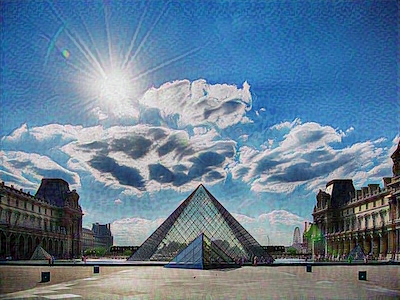

Epoch 300 



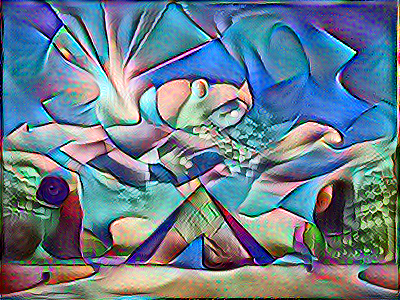

Epoch 600 



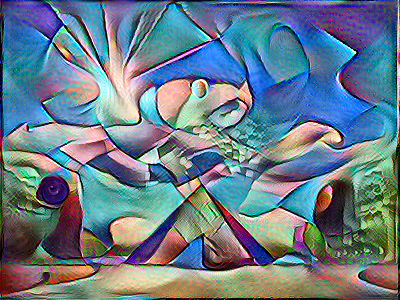

Epoch 900 



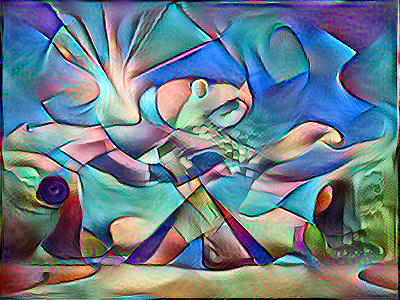

Epoch 1200 



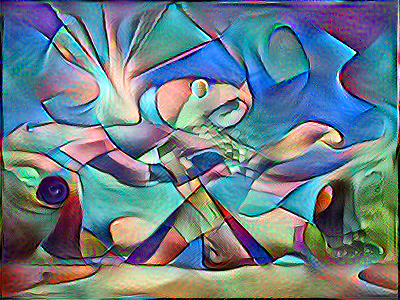

Epoch 1500 



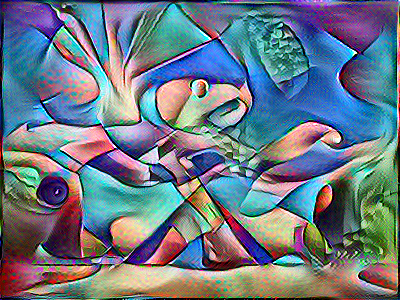

Epoch 1800 



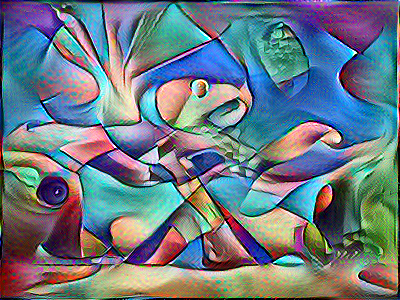

In [272]:
# comment if you don't want to start over with each tryout
generated_image = None
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

if ADD_NOISE:
    generated_image = add_noise(generated_image, NOISE_RANGE)

def generator():
    for i in range(EPOCHS):
        train_step(generated_image, ALPHA, BETA)
        if i % EPOCHS_PER_IMAGE_OUTPUT == 0:
            print(f"Epoch {i} \n")
            image = tensor_to_image(generated_image)

            if cv2_imshow:
                cv2_imshow(image)
            else:
                cv2.imshow(image)

            cv2.imwrite(f"image_{i}_lr_{LEARNING_RATE}_a_{ALPHA}_b_{BETA}.jpg", image)


generator()
